# Restricted Boltzmann Machine

### Data and packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.utils import shuffle
FILE = loadmat('binaryalphadigs.mat')

### Initiliztion of the RBM's weights and bias

In [12]:
def init_RBM(p,q):
    RBM = {} 
    RBM['a'] = np.zeros((1,p))
    RBM['b'] = np.zeros((1,q))
    RBM['w'] = 0.01 * np.random.rand(p,q)
    
    return RBM

### Convert input data to matrix

In [4]:
def lire_alpha_digit(FILE_dat, idx):
     
    imgs = FILE_dat[idx,:].flatten()
    imgs_flatten = []
    for img in imgs:
        imgs_flatten.append(img.flatten())
    
    return np.array(imgs_flatten)

### Get output values using an RBM structure and input data

In [5]:
def entree_sortie_RBM(RBM, donnee):
    
    b = RBM['b'].reshape(1,-1)
    w = RBM['w']
    n = donnee.shape[0]
    sortie = 1 / (1 + np.exp(- b - donnee @ w ))
    
    return sortie

### Get input values using and RBM structure and output data

In [6]:
def sortie_entree_RBM(RBM, donnee):
    
    a = RBM['a'].reshape(1,-1)
    w = RBM['w']
    n = donnee.shape[0]
    entree = 1 / (1 + np.exp(- a - donnee @ w.T))
                  
    return entree

### Using Contrastive-Divergence-1 to train the RBM (unsupervised learning):

### Details [here](http://deeplearning.net/tutorial/rbm.html)

In [7]:
def train_RBM(RBM, donnee, n_hidden, n_iteration, learning_rate, size_batch):
    
    loss   = np.zeros(n_iteration)
    donnee = shuffle(donnee)
    n      = donnee.shape[0]
    q      = n_hidden
    p      = donnee.shape[1]
    
    for i in np.arange(0, n_iteration):
        
        for batch in np.arange(0, n, size_batch):
            
            index_batch = np.arange(batch, min(batch + size_batch,n))
            x = donnee[index_batch,:]
        
            # tirage monte carlo
            v_0   = x
            p_hv0 = entree_sortie_RBM(RBM, v_0)
            h_0   = (np.random.rand(v_0.shape[0], q) < p_hv0).astype('float')
            p_vh0 = sortie_entree_RBM(RBM, h_0)
            v_1   = (np.random.rand(v_0.shape[0], p) < p_vh0).astype('float')
            p_hv1 = entree_sortie_RBM(RBM, v_1)
            
            # calcul gradient
            d_a = np.sum(v_0 - v_1, axis=0) / v_0.shape[0]
            d_b = np.sum(p_hv0 - p_hv1, axis=0) / v_0.shape[0]
            d_W = (v_0.T @ p_hv0 - v_1.T @ p_hv1) / v_0.shape[0] # produit vectoriel

            # mise a jour
            RBM['a'] = RBM['a'] + learning_rate * d_a
            RBM['b'] = RBM['b'] + learning_rate * d_b
            RBM['w'] = RBM['w'] + learning_rate * d_W
            
        sortie = entree_sortie_RBM(RBM, donnee)
        
        entree_reconstruite = sortie_entree_RBM(RBM, sortie)

        loss[i] = np.sum((entree_reconstruite - donnee)**2)/(n*p)
        
    return RBM, loss

### Generate samples of images from the RBM using Gibbs sampling:

In [13]:
def generer_image(RBM, n_image, n_iteration, string):
    
    p = RBM["w"].shape[0]
    q = RBM["w"].shape[1]
    plt.figure(figsize=(20,10))
    for i in range(n_image):
        v = (np.random.rand(p) < 0.5).astype('float')
        for j in range(n_iteration):
            h = (np.random.rand(q) < entree_sortie_RBM(RBM, v)).astype('float')
            v = (np.random.rand(p) < sortie_entree_RBM(RBM, h)).astype('float')
        
        plt.subplot(int(n_image/5),5,i+1)
        plt.imshow(1-v.reshape(20,16),cmap='gray')
        plt.axis('off')
    plt.suptitle(string)
    plt.show()
        

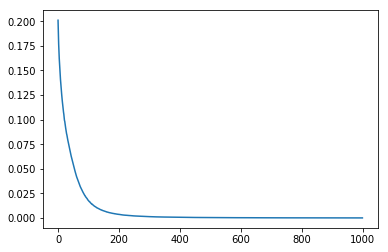

In [14]:
# Hyper-parameters settings and training

index         = [10,11,12]
donnee        = lire_alpha_digit(FILE['dat'], index)
n_hidden      = 200
n_iteration   = 1000
learning_rate = 0.1
size_batch    = 10
RBM           = init_RBM(donnee.shape[1], n_hidden)
RBM, loss     = train_RBM(RBM, donnee, n_hidden, n_iteration, learning_rate, size_batch)

plt.plot(loss)
plt.show()

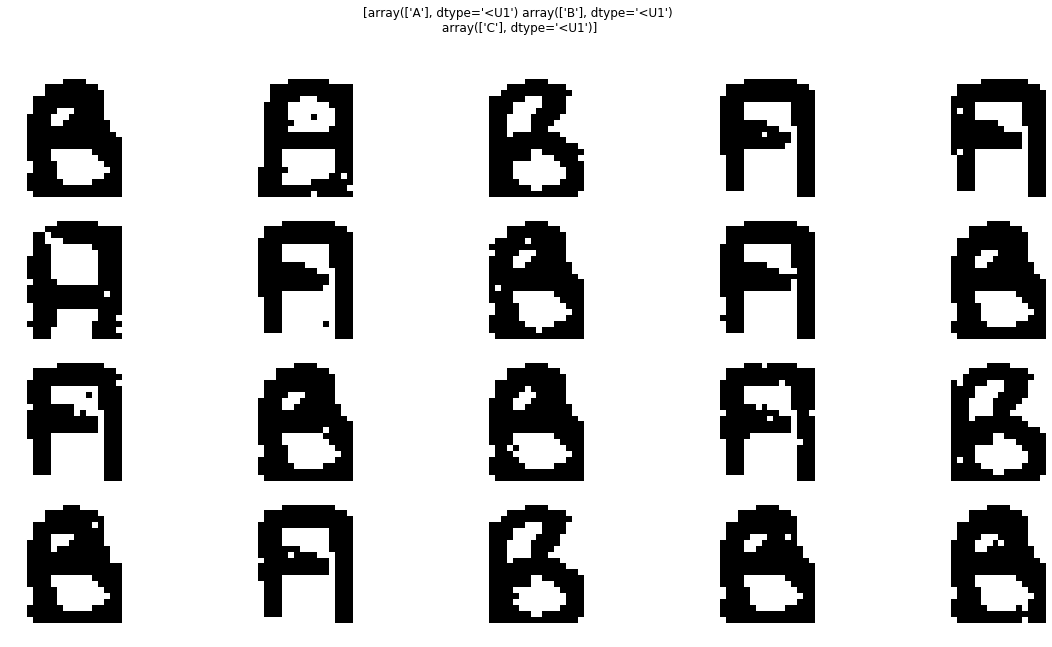

In [15]:
# Images sampling

n_iteration = 1000
n_image = 20
generer_image(RBM, n_image, n_iteration, str(FILE['classlabels'][0,index]))